In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files


In [23]:
# Загрузка данных
images = np.load('images.npy')
labels = np.load('labels.npy')
images_sub = np.load('images_sub.npy')


In [24]:
# Нормализация изображений (приводим пиксели к диапазону [0, 1])
images = images.astype('float32') / 255.0
images_sub = images_sub.astype('float32') / 255.0
print(f"Размер обучающих изображений: {images.shape}")
print(f"Размер меток: {labels.shape}")
print(f"Размер тестовых изображений: {images_sub.shape}")


Размер обучающих изображений: (20000, 48, 48, 3)
Размер меток: (20000,)
Размер тестовых изображений: (50000, 48, 48, 3)


In [25]:
# Проверка типа данных и диапазона
print(f"Диапазон пикселей после нормализации: {images.min()} - {images.max()}")

Диапазон пикселей после нормализации: 0.0 - 1.0


In [26]:
# One-hot кодировка меток классов
labels_cat = to_categorical(labels, num_classes=26)
print(f"Размер меток после One-Hot Encoding: {labels_cat.shape}")

# Разделение на обучение и валидацию
X_train, X_val, y_train, y_val = train_test_split(images, labels_cat, test_size=0.1, random_state=42)
print(f"Размер обучающей выборки (X_train): {X_train.shape}")
print(f"Размер валидационной выборки (X_val): {X_val.shape}")

Размер меток после One-Hot Encoding: (20000, 26)
Размер обучающей выборки (X_train): (18000, 48, 48, 3)
Размер валидационной выборки (X_val): (2000, 48, 48, 3)



Примеры обучающих изображений:


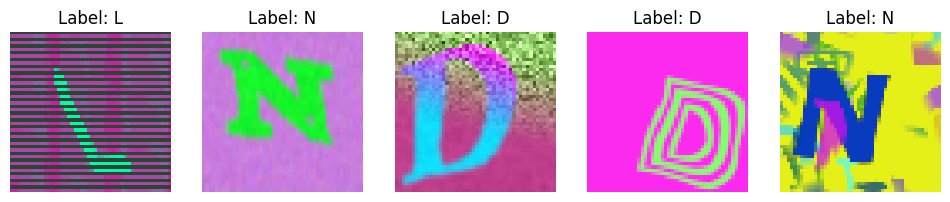

In [27]:
# Визуализация нескольких изображений
def plot_random_images(X, y, num_images=5):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])
        # Преобразуем one-hot обратно в класс, а затем в букву
        label = np.argmax(y[idx])
        plt.title(f"Label: {chr(65 + label)}") # 65 - ASCII код для 'A'
        plt.axis('off')
    plt.show()

print("\nПримеры обучающих изображений:")
plot_random_images(X_train, y_train)

In [28]:
#аугментация данных
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [29]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, Input


def my_cnn(input_shape=(48, 48, 3), num_classes=26):
    model = Sequential()

    # Input layer (официальный способ)
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Classifier
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model



In [30]:

model = my_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.0557 - loss: 3.6441 - val_accuracy: 0.0900 - val_loss: 3.1184
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.3276 - loss: 2.2897 - val_accuracy: 0.6755 - val_loss: 1.0702
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.5940 - loss: 1.3200 - val_accuracy: 0.7530 - val_loss: 0.7962
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.7024 - loss: 0.9586 - val_accuracy: 0.8180 - val_loss: 0.6111
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7557 - loss: 0.7712 - val_accuracy: 0.8525 - val_loss: 0.4605
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.8050 - loss: 0.6228 - val_accuracy: 0.8815 - val_loss: 0.3961
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.8329 - loss: 0.5427 - val_accuracy: 0.8900 - val_loss: 0.3516
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.8490 - loss: 0.4755 - val_accu

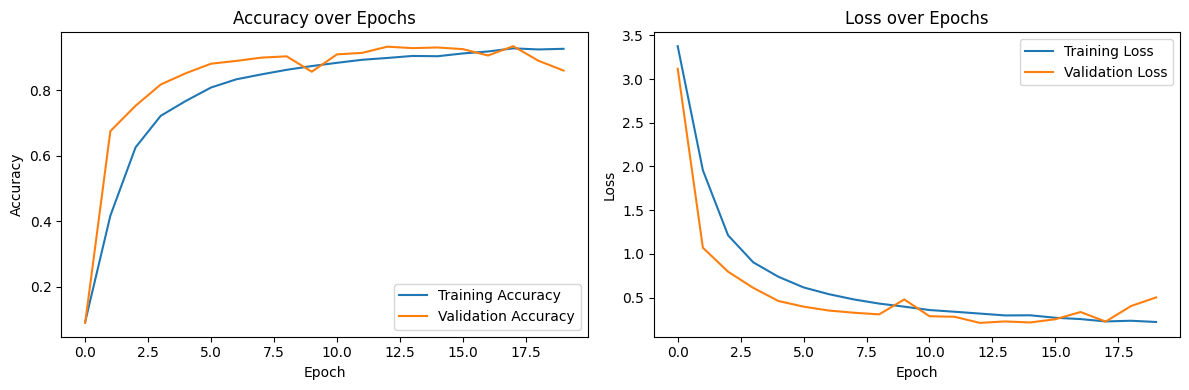

In [31]:
#графики обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [32]:
#Предсказание и создание submission
predictions = model.predict(images_sub)
predicted_classes = np.argmax(predictions, axis=1)



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 213s 136ms/step


In [35]:
submission = pd.read_csv('sample_submission.csv')

submission['Category'] = predicted_classes

submission.to_csv('submission.csv', index=False)

files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>